In [27]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
from time import time
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
import torch

from IPython.display import HTML, Video

# Visualization
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.colors as colors
from analysis_funcs import calc_rad_tubulin_intensity, get_sorted_time_grps


single_cent_dir = Path.cwd() / "../examples/single_centrosome_no_interaction_2d/"


In [28]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
}
plt.style.use(graph_sty)

In [29]:
class LineDataUnits(Line2D):
    """!Class that rescales a 2D matplotlib line to have the proper width and
    length with respect to axis unit values.
    """

    def __init__(self, *args, **kwargs):
        _lw_data = kwargs.pop("linewidth", 1)
        super().__init__(*args, **kwargs)
        self._lw_data = _lw_data

    def _get_lw(self):
        if self.axes is not None:
            ppd = 72.0 / self.axes.figure.dpi
            trans = self.axes.transData.transform
            return ((trans((1, self._lw_data)) - trans((0, 0))) * ppd)[1]
        else:
            return 1

    def _set_lw(self, lw):
        self._lw_data = lw

    _linewidth = property(_get_lw, _set_lw)


def draw_filament(
    ax, minus_pos, dir_vec, L, rod_diam, color="tab:green", tip_color="b", x=0, y=1
):
    """!Draw a diagramitic representation of a rod on a matplotlib axis object."""
    line = LineDataUnits(
        (minus_pos[x], minus_pos[x] + L * dir_vec[x]),
        (minus_pos[y], minus_pos[y] + L * dir_vec[y]),
        linewidth=rod_diam,
        solid_capstyle="round",
        color=color,
        clip_on=False,
    )

    tip = Circle(
        (minus_pos[x] + L * dir_vec[x], minus_pos[y] + L * dir_vec[y]),
        0.5 * rod_diam,
        color=tip_color,
        zorder=3,
    )
    ax.add_patch(tip)
    ax.add_line(line)

In [ ]:
def make_aster_movie(data_path, save_path):
    diam = 0.025

    h5_data = h5py.File(data_path, "r")

    try:
        fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
        time_grps = get_sorted_time_grps(h5_data)
        # tmp = [grp for grp in h5_data]
        # print( tmp )
        # time_grps = sorted(
        #     [grp for grp in h5_data], key=lambda x: int(re.findall(r"\d+", x)[0])
        # )

        # Get max distances
        first_fils = h5_data[time_grps[0]]["filaments"][...]
        last_fils = h5_data[time_grps[-1]]["filaments"][...]
        # min_x = first_fils[:,1].min()
        max_x = abs(last_fils[:, 1] + last_fils[:, 4] * last_fils[:, 7]).max()
        min_x = -max_x

        max_y = abs(last_fils[:, 2] + last_fils[:, 5] * last_fils[:, 7]).max()
        min_y = -max_y
        # min_y = (last_fils[:,2] + last_fils[:,5]*last_fils[:,7]).min()

        max_z = abs(last_fils[:, 3] + last_fils[:, 6] * last_fils[:, 7]).max()
        min_z = -max_z
        # min_z = (last_fils[:,3] + last_fils[:,6]*last_fils[:,7]).amin()

        def draw_all_filaments(ax, t_grp, x=0, y=1):
            filaments = h5_data[t_grp]["filaments"][...]
            nucleators = h5_data[t_grp]["nucleators"][...]
            for fil in filaments:
                draw_filament(ax, fil[1:4], fil[4:7], fil[7], diam, x=x, y=y)
            for nuc in nucleators:
                if nuc[1] == -1 or filaments.size == 0:
                    continue
                try:
                    fil_with_nuc = filaments[np.where(filaments[:, 0] == nuc[1])][0]
                except:
                    print("Nuc id:", nuc[0])
                    print("Nuc pos:", nuc[3])
                    print("Nuc MT bound:", nuc[1])
                    print("Current fils:", filaments[:, 0])
                    raise
                nuc_pos = fil_with_nuc[1:4] + fil_with_nuc[4:7] * nuc[3]

                nuc_art = Circle(
                    (nuc_pos[x], nuc_pos[y]),
                    diam,
                    color="tab:red",
                    zorder=3,
                )
                ax.add_patch(nuc_art)
                # ax.plot(nuc_pos[x], nuc_pos[y], 'o', color='tab:red', markersize=5)
            # axarr[0].set_xlim(min_x, max_x)
            # axarr[0].set_ylim(min_y, max_y)
            # axarr[1].set_xlim(min_x, max_x)
            # axarr[1].set_ylim(min_z, max_z)

        def draw_centrosomes(ax, t_grp, x=0, y=1):
            centrosomes = h5_data[t_grp]["centrosomes"][...]
            for cent in centrosomes:
                cent_art = Circle(
                    (cent[x + 1], cent[y + 1]),
                    cent[4],
                    color="tab:purple",
                    zorder=3,
                )
                ax.add_patch(cent_art)

        def init():
            draw_all_filaments(axarr[0], time_grps[0], x=0, y=1)
            draw_all_filaments(axarr[1], time_grps[0], x=0, y=2)
            for ax in axarr:
                ax.set_aspect("equal")
            axarr[0].set_xlim(min_x, max_x)
            axarr[0].set_ylim(min_y, max_y)
            # axarr[1].set_xlim(min_x, max_x)
            # axarr[1].set_ylim(min_z, max_z)
            # ax.set_xlim(x_low, x_high)
            # ax.set_ylim(y_low, y_high)

            axarr[0].set_xlabel(r"x $[\mu m]$")
            axarr[0].set_ylabel(r"y $[\mu m]$")

            axarr[1].set_xlabel(r"x $[\mu m]$")
            axarr[1].set_ylabel(r"z $[\mu m]$")

            fig.suptitle(f"t = {float(time_grps[0].split('_')[-1]):.2f}")
            fig.tight_layout()
            return fig.gca().lines + fig.gca().collections

        def animate(i):
            # i*=10
            start_time = time()

            for ax in axarr:
                ax.clear()
                for artist in ax.lines + ax.collections:
                    artist.remove()
                    del artist
                # for artist in fig.gca().lines + fig.gca().collections:
                #     artist.remove()
                #     del artist
                ax.set_aspect("equal")
            axarr[0].set_xlim(min_x, max_x)
            axarr[0].set_ylim(min_y, max_y)
            # axarr[1].set_xlim(min_x, max_x)
            # axarr[1].set_ylim(min_z, max_z)

            draw_all_filaments(axarr[0], time_grps[i], x=0, y=1)
            draw_all_filaments(axarr[1], time_grps[i], x=0, y=2)
            # If there is a centrosome grp, draw centrosomes
            if "centrosomes" in h5_data[time_grps[i]]:
                draw_centrosomes(axarr[0], time_grps[i], x=0, y=1)
                draw_centrosomes(axarr[1], time_grps[i], x=0, y=2)

            fig.suptitle(f"t = {float(time_grps[i].split('_')[-1]):.2f}")

            axarr[0].set_xlabel(r"x $[\mu m]$")
            axarr[0].set_ylabel(r"y $[\mu m]$")

            axarr[1].set_xlabel(r"x $[\mu m]$")
            axarr[1].set_ylabel(r"z $[\mu m]$")
            # draw_all_filaments(axarr, time_grps[i])
            fig.tight_layout()
            print(
                f"On frame {i + 1} of {len(time_grps)}. Frame took  {time() - start_time:.2f}s to draw",
                end="\r",
            )
            return fig.gca().lines + fig.gca().collections

        ani = animation.FuncAnimation(
            fig, animate, init_func=init, frames=len(time_grps), interval=60, blit=True
        )
        ani.save(save_path, writer="ffmpeg", fps=30)

        plt.close(fig)
        del axarr
        del fig
    except:
        raise
    finally:
        h5_data.close()

    # return fig, axarr, ani

In [ ]:
# Make a movie of the single centrosome example using matplotlib (takes ~6 mins)
data_path = single_cent_dir / "single_cent.h5"
video_path = single_cent_dir / "test_cent.mp4"

make_aster_movie(data_path, video_path)
Video(video_path, embed=True)

/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59303/1713627221.py:80: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axarr[1].set_ylim(min_z, max_z)
/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59303/1713627221.py:80: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axarr[1].set_ylim(min_z, max_z)
/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_59303/1713627221.py:110: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axarr[1].set_ylim(min_z, max_z)


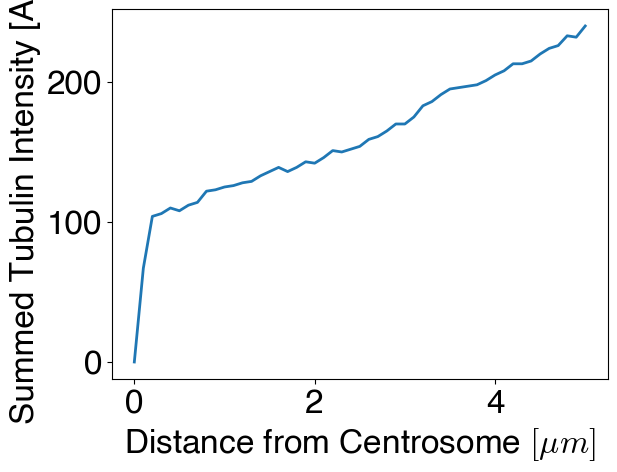

In [30]:
data_path = single_cent_dir / "single_cent.h5"

with h5py.File(data_path, "r") as h5_data:
    # print(h5_data.keys())
    filaments = h5_data["t_59.0"]["filaments"][...]

r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
    torch.tensor(filaments), torch.tensor([0, 0, 0]), bin_width=0.1, max_dist=5
)

_ = plt.plot(r_bins, n_fils_arrs)
_ = plt.xlabel(r"Distance from Centrosome $[\mu m]$")
_ = plt.ylabel(r"Summed Tubulin Intensity [AU]")

/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_60490/2047996666.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dens_hist[:, i] = n_fils_arrs[:-1] / (4 * np.pi * np.power(r_bins[1:], 2))


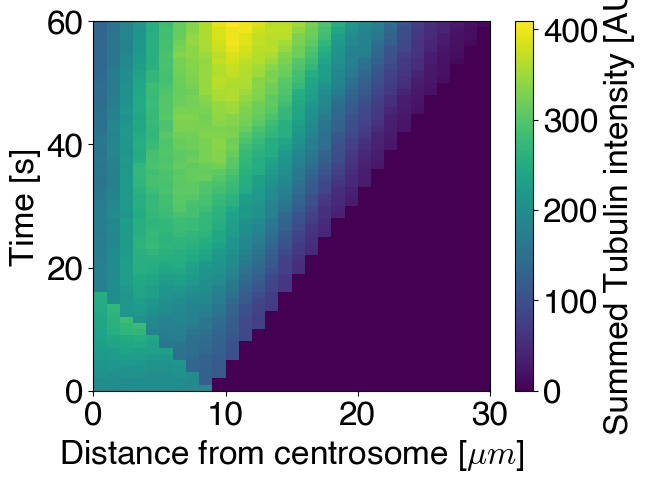

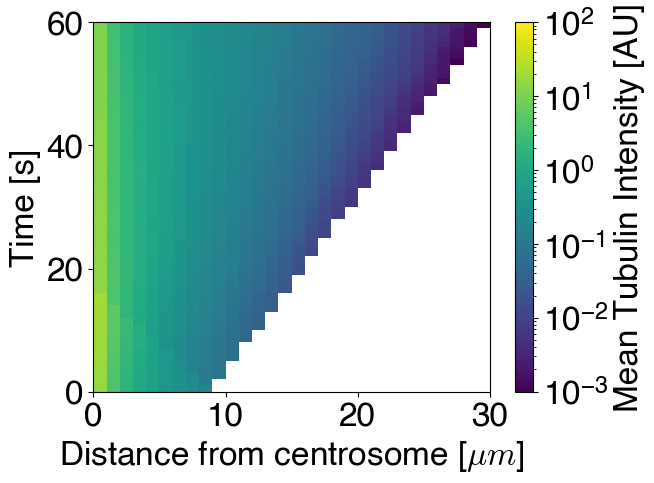

In [42]:
# About 2 minutes to run
data_path = single_cent_dir / "single_cent.h5"
bin_width = 1
max_dist = 30


with h5py.File(data_path, "r") as h5_data:
    # print(h5_data.keys())
    time_grps = get_sorted_time_grps(h5_data)
    hist = torch.zeros((int(max_dist / bin_width), len(time_grps)))
    dens_hist = torch.zeros((int(max_dist / bin_width), len(time_grps)))
    for i, t_grp in enumerate(time_grps):
        # print(t_grp)
        filaments = h5_data[t_grp]["filaments"][...]
        r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
            torch.tensor(filaments),
            torch.tensor([0, 0, 0]),
            bin_width=bin_width,
            max_dist=max_dist,
        )
        hist[:, i] = n_fils_arrs[:-1]
        dens_hist[:, i] = n_fils_arrs[:-1] / (4 * np.pi * np.power(r_bins[1:], 2))
    X, Y = np.meshgrid(r_bins, np.arange(0, hist.shape[1] + 1))


_ = plt.pcolormesh(X, Y, hist.T)
_ = plt.xlabel(r"Distance from centrosome [$\mu m$]")
_ = plt.ylabel("Time [s]")
_ = plt.colorbar(label="Summed Tubulin intensity [AU]")

_ = plt.figure()

_ = plt.pcolormesh(
    X,
    Y,
    dens_hist.T,
    norm=colors.LogNorm(vmin=1e-3, vmax=100),
)
_ = plt.xlabel(r"Distance from centrosome [$\mu m$]")
_ = plt.ylabel("Time [s]")
_ = plt.colorbar(label="Mean Tubulin Intensity [AU]")

with h5py.File(
    data_path.parent / (str(data_path.parent.stem) + "_analyzed.h5"), "w"
) as h5_data:
    _ = h5_data.create_dataset("time", data=np.arange(0, hist.shape[1] + 1))
    _ = h5_data.create_dataset("r_bins", data=r_bins)
    _ = h5_data.create_dataset("tot_tubulin_intensity", data=hist)
    _ = h5_data.create_dataset("avg_tubulin_intensity", data=dens_hist)

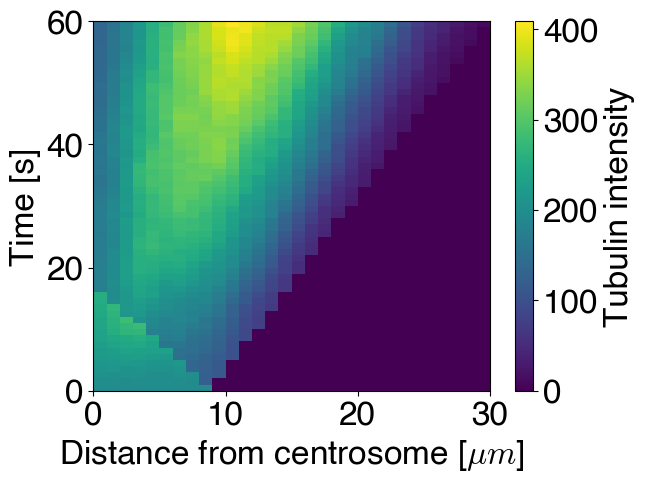

In [41]:
data_path = single_cent_dir / "single_cent.h5"
bin_width = 1
max_dist = 30

with h5py.File(data_path, "r") as h5_data:
    time_grps = get_sorted_time_grps(h5_data)
    hist = torch.zeros((int(max_dist / bin_width), len(time_grps)))
    for i, t_grp in enumerate(time_grps):
        # print(t_grp)
        filaments = h5_data[t_grp]["filaments"][...]
        r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
            torch.tensor(filaments),
            torch.tensor([0, 0, 0]),
            bin_width=bin_width,
            max_dist=max_dist,
        )
        hist[:, i] = n_fils_arrs[:-1]
    X, Y = np.meshgrid(r_bins, np.arange(0, hist.shape[1] + 1))

# print(X)

# plt.pcolormesh(X,Y,hist)
_ = plt.pcolormesh(X, Y, hist.T)
_ = plt.xlabel(r"Distance from centrosome [$\mu m$]")
_ = plt.ylabel("Time [s]")
_ = plt.colorbar(label="Tubulin intensity")

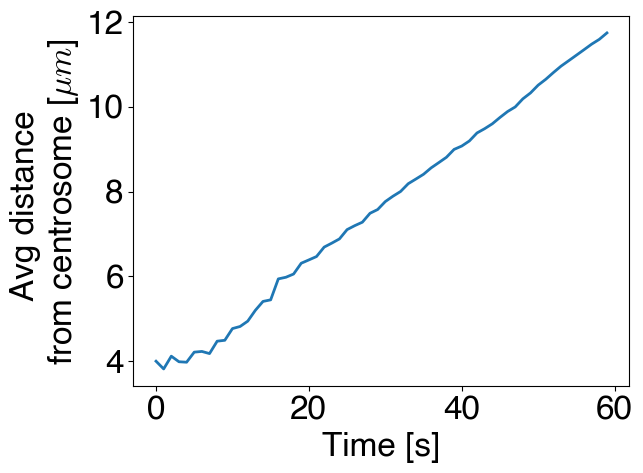

In [43]:
data_path = single_cent_dir / "single_cent.h5"
bin_width = 1
max_dist = 30


with h5py.File(data_path, "r") as h5_data:
    time_grps = get_sorted_time_grps(h5_data)
    hist = torch.zeros((int(max_dist / bin_width), len(time_grps)))
    for i, t_grp in enumerate(time_grps):
        # print(t_grp)
        filaments = h5_data[t_grp]["filaments"][...]
        r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
            torch.tensor(filaments),
            torch.tensor([0, 0, 0]),
            bin_width=bin_width,
            max_dist=max_dist,
        )
        hist[:, i] = n_fils_arrs[:-1]
    X, Y = np.meshgrid(r_bins, np.arange(0, hist.shape[1] + 1))

# Find the average distance of the tubulin intensity over time
avg_dist = np.einsum("ij,i->j", hist, r_bins[:-1]) / hist.sum(axis=0)
_ = plt.plot(Y[:-1, 0], avg_dist)


_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Avg distance \n" + r"from centrosome [$\mu m$]")

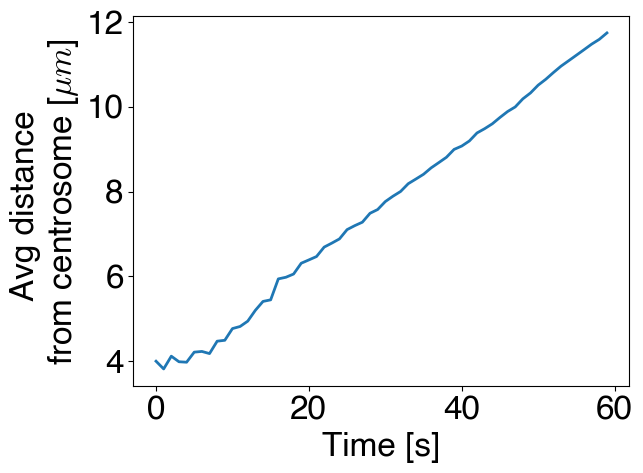

In [38]:
data_path = single_cent_dir / "single_cent.h5" 
bin_width = 1
max_dist = 30


with h5py.File(data_path, "r") as h5_data:
    time_grps = get_sorted_time_grps(h5_data)
    hist = torch.zeros((int(max_dist / bin_width), len(time_grps)))
    for i, t_grp in enumerate(time_grps):
        filaments = h5_data[t_grp]["filaments"][...]
        r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
            torch.tensor(filaments),
            torch.tensor([0, 0, 0]),
            bin_width=bin_width,
            max_dist=max_dist,
        )
        hist[:, i] = n_fils_arrs[:-1]
    # X, Y = np.meshgrid(r_bins, np.arange(0, hist.shape[1]+1))
    X, Y = np.meshgrid(r_bins, np.arange(0, hist.shape[1] + 1))

# Find the average distance of the tubulin intensity over time
avg_dist = np.einsum("ij,i->j", hist, r_bins[:-1]) / hist.sum(axis=0)
_ = plt.plot(Y[:-1, 0], avg_dist)


_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Avg distance \n" + r"from centrosome [$\mu m$]")

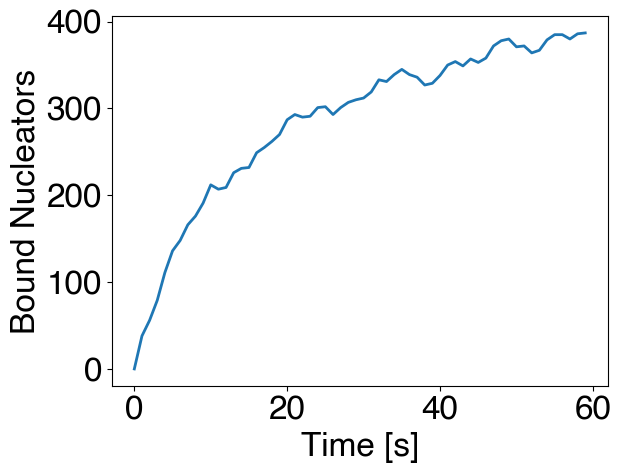

In [39]:
data_path = single_cent_dir / "single_cent.h5"
bin_width = 1
max_dist = 30


n_bound_nucs = []
with h5py.File(data_path, "r") as h5_data:
    time_grps = get_sorted_time_grps(h5_data)
    for i, t_grp in enumerate(time_grps):
        nucleators = h5_data[t_grp]["nucleators"][...]
        # Nucleators bound
        n_bound_nucs.append(nucleators[nucleators[:, 3] > 0].shape[0])

_ = plt.plot(n_bound_nucs)
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Bound Nucleators")

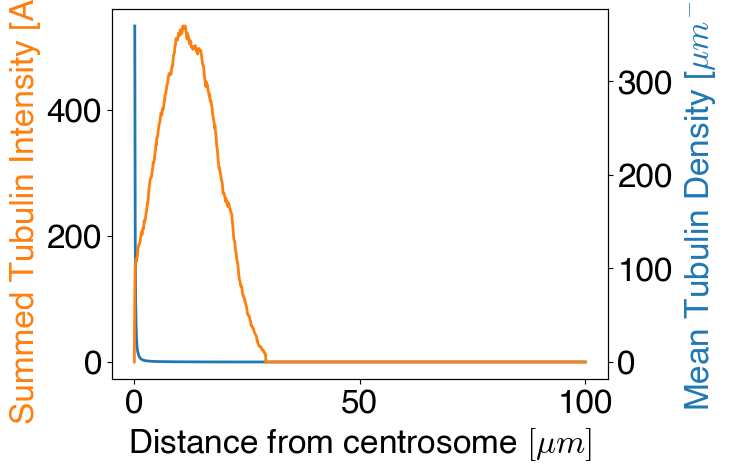

In [40]:
data_path = single_cent_dir / "single_cent.h5"

with h5py.File(data_path, "r") as h5_data:
    filaments = h5_data["t_59.0"]["filaments"][...]

r_bins, n_fils_arrs = calc_rad_tubulin_intensity(
    torch.tensor(filaments), torch.tensor([0, 0, 0]), bin_width=0.1, max_dist=100
)

fig, ax = plt.subplots()
_ = ax.plot(r_bins, n_fils_arrs / (4 * np.pi * (r_bins**2)))
# Plot on a different axis
_ = ax2 = ax.twinx()
_ = ax2.plot(r_bins, n_fils_arrs, color="tab:orange")
_ = ax.set_xlabel(r"Distance from centrosome $[\mu m]$")
_ = ax2.set_ylabel(r"Mean Tubulin Density [$\mu m^{-3}$]", color="tab:blue")
_ = ax.set_ylabel(r"Summed Tubulin Intensity [AU]", color="tab:orange")
# print(n_fils_arrs.sum())